# Project 2: Solution 
Copyright © 2017 Oliver Beckstein. All Rights Reserved.

## Goal and Objectives

Simulate the movements of planets near the star TRAPPIST-1

1. Simulate movement of the 6 closest planets (b, c, d, e, f, g) for 1000 earth days
2. From which planets can an observer see the most other planets so close that one could resolve features of size 1000 km by naked eye?

The Space Tourism Bureau suggests TRAPPIST-1e (see poster below). Are they right?

![Planet Hop from TRAPPIST-1e. Voted best "Hab Zone" vacation within 12 parsecs of Earth](https://exoplanets.nasa.gov/system/resources/detail_files/2159_posternormalsize.jpg)
(From [NASA Exoplanet Exploration: Galleries: TRAPPIST-1](https://exoplanets.nasa.gov/resources/2159/?linkId=34784370).)

## Outline of a Solution

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

Most of the code is in the module `simulation`. First load system parameters from `parameters`.

In [3]:
import parameters
import simulation
import analysis

from parameters import planets, star

In [4]:
from importlib import reload
reload(simulation)
reload(analysis)

<module 'analysis' from '/Volumes/Data/oliver/Documents/Teaching/ASU/CompPhys_PHY494/2017/Projects/P2/solution/analysis.py'>

## Orbits with star fixed 

### Initial conditions

In [5]:
planets_x = simulation.rmax(planets['semi-major'], planets['eccentricity'])
planets_vy = simulation.v_aphelion(planets['semi-major'], planets['eccentricity'], M=star['mass'])

r0 = np.array([planets_x, np.zeros_like(planets_x)]).T
v0 = np.array([np.zeros_like(planets_vy), planets_vy]).T
planet_masses = planets['mass']
masses = np.concatenate(([star['mass']], planet_masses))

### Simulation 

Test that the integration is (likely) correct and reproduces the period for the innermost planet: Check visually that after 1.5 d, TRAPPIST-1b has almost completed one revolution (period 1.51 d).

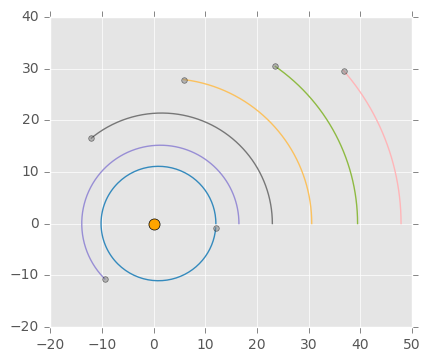

In [6]:
t, r, v = simulation.orbits(r0, v0, planet_masses, t_max=1.5, dt=0.01)
analysis.plot_orbits(r)

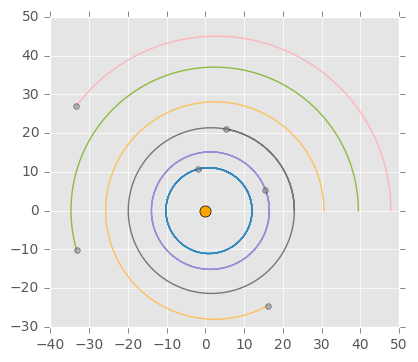

In [7]:
t, r, v = simulation.orbits(r0, v0, planet_masses, t_max=5, dt=0.01)
analysis.plot_orbits(r)

Run the simulation for 1000 d.

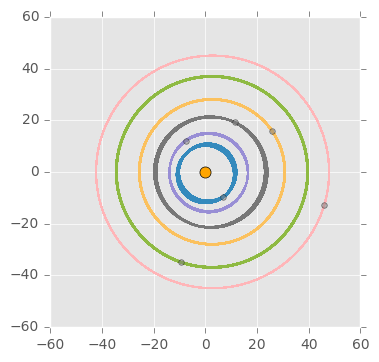

In [8]:
t, r, v = simulation.orbits(r0, v0, planet_masses, t_max=1000, dt=0.01)
analysis.plot_orbits(r)

### Energy conservation
Test energy conservation

$$
E = T + U = \text{const}
$$

for the 1000-d run.

The `kinetic_energy()` function compute the kinetic energy for each planet and time step. To get the system energies, we have to sum over all bodies (`axis=-1`) but we also need to compute the potential energy for *all* $N$-body interactions

$$
U = \frac{1}{2} \sum_{i=1}^N \sum_{j=1, j\neq i}^N \left( - \frac{G m_i m_j}{r_{ij}} \right)
$$

(as implemented in `simulation.U_tot()`). The total energy as a function of time

$$
E(t) = T(t) + U(t)
$$

or in code:

```python
T = np.sum(analysis.kinetic_energy(v, masses), axis=-1)
U = np.array([simulation.U_tot(rt, masses) for rt in r])
E_tot = T + U
```

(`U_tot()` can only operate on individual frames of the trajectory, so we need to loop and put the results into an array.)

Note that for the analysis we provide all masses, not just the planet masses:

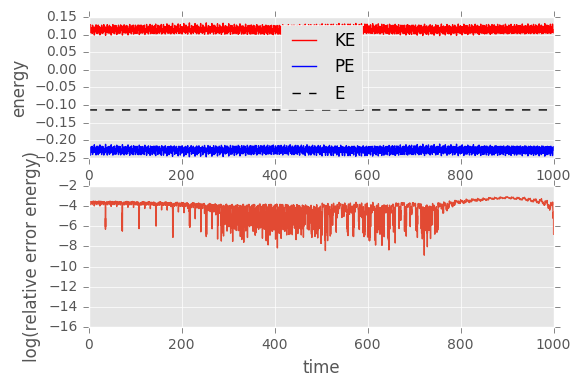

In [9]:
analysis.analyze_energies(t, r, v, simulation.U_tot, m=masses)

Energy conservation is acceptable, given the time step of `dt = 0.01`. (The unit of time is 1 so for the step of $10^{-2}$ we expect an error on the order of $\Delta t^2$, i.e., $10^{-4}$ as seen.)

## BONUS: Star wobble 

Allow the central star to move, too, but set initial conditions so that the total momentum is 0. (Total momentum is conserved by velocity Verlet, and thus the center of mass of our simulation will remain fixed during the simulation.)

In [10]:
# planets 
r0 = np.array([planets_x, np.zeros_like(planets_x)]).T
v0 = np.array([np.zeros_like(planets_vy), planets_vy]).T

# prepend star
r0_system = np.vstack((np.array([[0, 0]]), r0))

# choose star velocity to make total momentum 0
p_planets = np.sum(planet_masses[:, np.newaxis] * v0, axis=0)
v0_star = -p_planets / star['mass']
v0_system = np.vstack((v0_star, v0))

NOTE: perhaps we should put the center of mass at 0 and move the star to


\begin{equation}
\mathbf{r}_{star} = - \frac{\sum_{i=1}^N m_i \mathbf{r}_i}{M_{star}},
\end{equation}


### Trajectories with star wobbling 

1000 d trajectory with very fine time step (as a base line); later we go back to 0.01d time step.

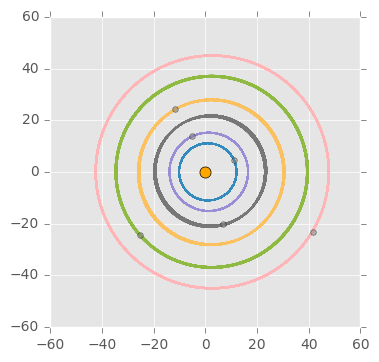

In [11]:
t, r, v = simulation.orbits2(r0_system, v0_system, masses, t_max=1000, dt=0.001)
analysis.plot_orbits2(r)

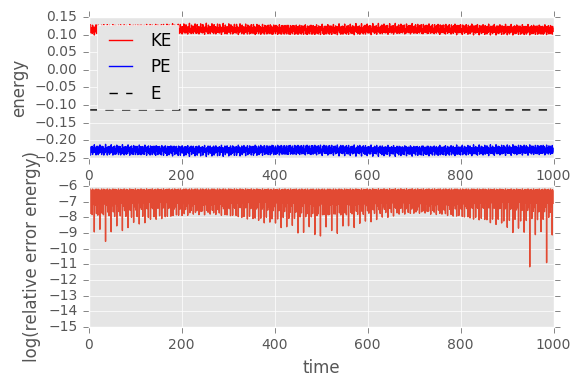

In [12]:
analysis.analyze_energies(t, r, v, simulation.U_tot, m=masses)

Simulate for 1000 d with standard $\Delta t = 0.01\,\text{d}$:

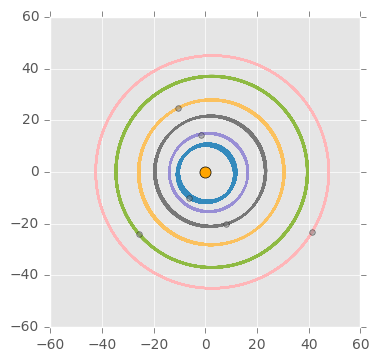

In [13]:
t, r, v = simulation.orbits2(r0_system, v0_system, masses, t_max=1000, dt=0.01)
analysis.plot_orbits2(r)

Note that the larger time step of 0.01 d introduces some inaccuracies in the inner orbits, compared to the trajectories for the 0.001 time step.

### Energy conservation with wobble

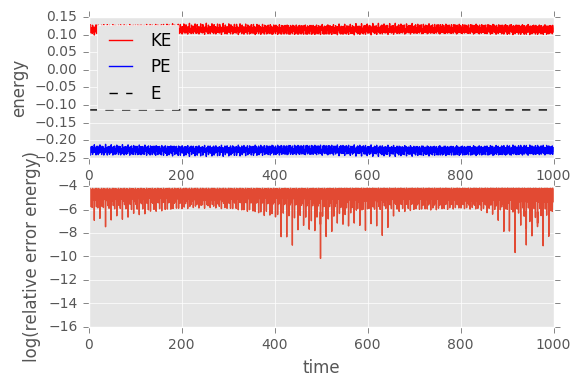

In [16]:
analysis.analyze_energies(t, r, v, simulation.U_tot, m=masses)

Qualitatively, the movement of the central star does not seem to affect the observed orbits and it also does not negatively affect the stability of the integrator. The relative accuracy is about $10^{-4}$, as expected for velocity Verlet's accuracy $\mathcal{O}(\Delta t^2/T)$ (where $T$ is the shortest time scale for an orbit, namely the orbital period of TRAPPIST-1b, 1.51 d) with a time step of $\Delta t/T \approx 10^{-2}$ and hence $\epsilon \approx (10^{-2})^2 = 10^{-4}$.

### Total momentum conservation
Analyze conservation of total system momentum:

$$
\mathbf{P}(t) = \sum_{i=1}^N m_i \mathbf{v}_i(t)
$$

Because we start with $P = 0$ we expect $P(t)$ to be close to 0 during the whole trajectory.

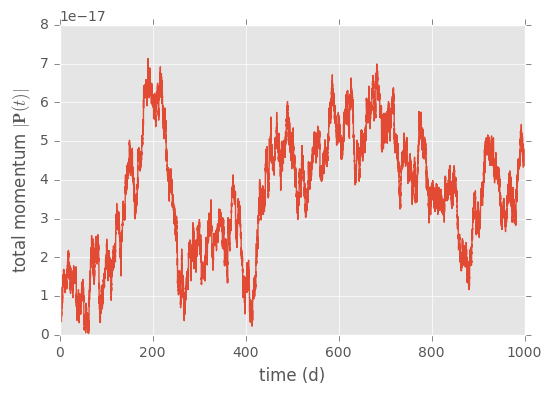

In [14]:
P = np.sum(v * masses[np.newaxis, :, np.newaxis], axis=1)   # total momentum vector P(t)
p = np.sqrt(np.sum(P*P, axis=-1))   # length of momentum vector
plt.plot(t, p)
plt.xlabel("time (d)")
plt.ylabel(r"total momentum $|\mathbf{P}(t)|$")

In [15]:
p.max()

7.1329132750160884e-17

The largest deviation is on the order of the machine precision. Therefore, momentum *is conserved* in our simulation to an excellent degree.

### Movement of the star 

Plot the movement of the center of the star for the first 5 days; the star's size is shown by an orange circle (which is much bigger than the area covered by the movement).

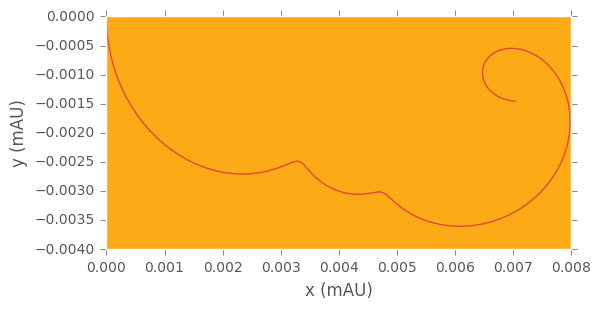

In [16]:
r_star = r[:int(5/0.01), 0][:, np.newaxis, :]
ax = analysis.plot_orbits_fancy2(r_star)
ax.set_xlabel("x (mAU)")
ax.set_ylabel("y (mAU)")

Movement of the star over 1000 d:

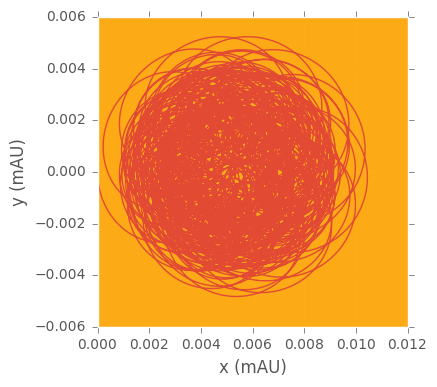

In [17]:
r_star = r[:, 0][:, np.newaxis, :]
ax = analysis.plot_orbits_fancy2(r_star)
ax.set_xlabel("x (mAU)")
ax.set_ylabel("y (mAU)")

Compare the extend of the movement to the size of the star itself (in mAU):

In [18]:
parameters.star_radius_localunits

0.544182879201903

The orbit of the star TRAPPIST-1a is inside the star itself. Thus the common center of mass of the system is inside the star itself and probably no clear wobble is observable. But we will check.

### Velocity analysis of TRAPPIST-1: Is the wobble detectable with Dopple spectroscopy? 

Could the wobble be observed by [Doppler spectroscopy](https://en.wikipedia.org/wiki/Doppler_spectroscopy) measurements? Third generation instruments are sensitive to 0.1 m/s.

Assume ideal observation geometry (namely, observation side on). We approximate the [radial velocity](https://en.wikipedia.org/wiki/Radial_velocity) by the y-component of the velocity, $v_y$. (In principle it is the projection of the velocity on the observation direction but the change in angle is going to be very small and not much different from 0 because the observation distances is so much larger than the extend of the star motion. We could have also picked $v_x$ or any other viewing direction to get a sense for the magnitudes involved.)

Compute the time series of star velocities and look at the maximum differences.

Transform from center-of-mass coordinates (simulation) to lab frame (observer) coordinates:

$$
\mathbf{v}_{*} = -\frac{\sum_{i=1}^{N_{\text{planets}}}
        m_{i}}{M_{\text{star}} + \sum_{i=1}^{N_{\text{planets}}} m_{i}}\mathbf{v}
$$

In [19]:
def v_observer(v_com, M_star, masses_planets):
    return - v_com * masses_planets.sum() / (M_star + masses_planets.sum())

In [20]:
v_star_com = v[:, 0]
v_star = v_observer(v_star_com, star['mass'], planet_masses)
vy_star = v_star[:, 1]  # in 1e-3 au/d
vy_star_ms = analysis.au2km(vy_star * 1e-3) * 1e3 / (24*3600)  # in m/s
dt = 0.01
time = dt * np.arange(0, len(vy_star))

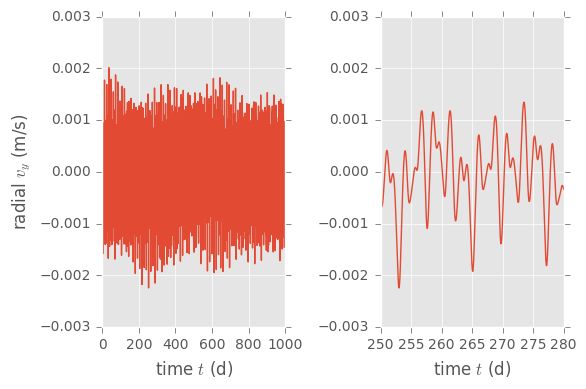

In [21]:
ax1 = plt.subplot(121)
ax1.plot(time, vy_star_ms)
ax1.set_xlabel(r"time $t$ (d)")
ax1.set_ylabel(r"radial $v_y$ (m/s)")
ax2 = plt.subplot(122)
ax2.plot(time, vy_star_ms)
ax2.set_xlabel(r"time $t$ (d)")
ax2.set_xlim(250, 280)
ax1.figure.tight_layout()

In [22]:
vy_max, vy_min = vy_star_ms.max(), vy_star_ms.min()
print("Delta v_radial = {0:.3f} m/s\nmax v_r = {1:.3f} m/s\nmin v_r = {2:.3f} m/s".format(vy_max-vy_min, vy_max, vy_min))

Delta v_radial = 0.004 m/s
max v_r = 0.002 m/s
min v_r = -0.002 m/s


Current Doppler spectroscopy can resolve velocities on the order of 1 m/s (and latest generation instruments can do perhaps 0.1 m/s) but the radial velocities for TRAPPIST-1 are still 1-2 orders of magnitude smaller. Therefore, the wobble cannot be detected with Doppler spectroscopy. (Instead, light curver measurements were used.)

## Analyze close planets

We want to count only planets as *nearby* by if we can resolve features of size `feature_size` with the nake eye:

In [23]:
feature_size = 1000 # km

Given the angular resolution of the naked eye ($\theta_\text{eye} = 1'$), we look for planets within a cutoff distance $d$ where features of size $y$ are still resolved:

$$
d(y) ≤ \frac{y}{\theta_\text{eye}}
$$


The critical distance is

In [24]:
d_max = analysis.dmax(feature_size)
print("{0:g} km".format(d_max))
print("{0:.1f} mAU".format(analysis.km2au(d_max) * 1e3))

3.43775e+06 km
23.0 mAU


Analyze the whole trajectory (here we are looking at the trajectory with the star allowed to wobble and so we remove the star from the trajectory with `r[:, 1:]`; qualitatively similar results are obtained when the star is fixed).

In [25]:
counts = analysis.find_nearby_planets(r[:, 1:], ymin=feature_size)

Plot the time series for TRAPPIST-1e (index 3 in the `counts` time series):

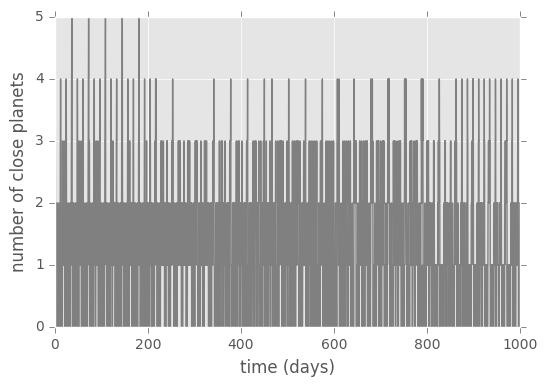

In [26]:
plt.plot(t, counts[:, 3], color="gray")
plt.xlabel("time (days)")
plt.ylabel(r"number of close planets")

Probability distribution for observing close planets:

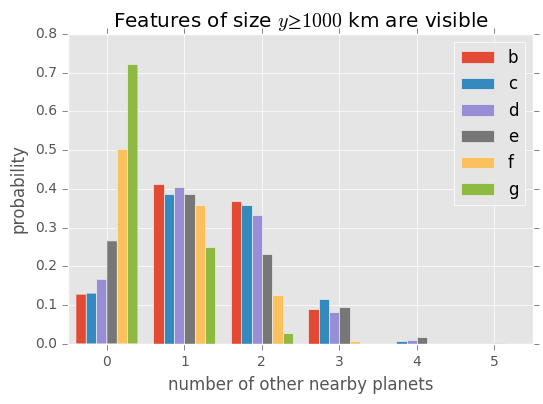

In [27]:
plt.hist(counts, bins=6, range=(-0.5, 5.5), normed=True, label=planets['name'])
plt.legend(loc="best")
plt.xlabel("number of other nearby planets")
plt.ylabel("probability")
plt.title("Features of size $y ≥ {}$ km are visible".format(feature_size))
plt.xlim(-0.5, 5.5);

In general, the inner planets (b, c, d) provide more opportunities to see other planets up close. However TRAPPIST-1e is the planet where one is most likely to see *four* other planets up close and it still has the third highest probability of any planet to have a close up view on *three* planets.

Only TRAPPIST-1d and TRAPPIST-1e see *five* planets at all:

In [28]:
np.sum(counts >= 5, axis=0)

array([  0,   0,  28, 266,   0,   0])

although it happens rarely. Still TRAPPIST-1e is 

In [29]:
266/28

9.5

about 9 times more likely to see five planets than the only other contender.

The probability of observing *five* planets is small, but non-zero: the table shows the probability that one can see $N$ other planets from a given planet:

In [30]:
# make probability density (histogram) from the time series of each planet separately
histograms = [np.histogram(counts[:, i], bins=6, range=(-0.5, 5.5), density=True) for i in range(counts.shape[1])]
_, edges = histograms[0]
n = 0.5*(edges[1:] + edges[:-1])  # number of planets

# formatting as a table (using only python)
row_format = "{:6s}" + "{:>8}" * len(n)
rule = "-" * len(row_format.format("x", *n))
print(rule + "\n" +
      row_format.format("planet", *n.astype(int)) + "\n" +
      rule)
for name, (probability, _) in zip(planets['name'], histograms):
    print(row_format.format(name, *np.round(probability * 100, decimals=2)))
print(rule)
print("Probability in % to observe N planets.")

------------------------------------------------------
planet       0       1       2       3       4       5
------------------------------------------------------
b        12.85   41.22   36.88    9.06     0.0     0.0
c        13.11   38.77   35.93   11.51    0.68     0.0
d        16.67   40.62   33.39     8.2    1.09    0.03
e         26.6   38.64    23.1    9.49    1.91    0.27
f        50.24   35.98   12.65    0.87    0.26     0.0
g        72.11    25.1     2.8     0.0     0.0     0.0
------------------------------------------------------
Probability in % to observe N planets.


Only about 0.27% of the time are 5 planets visible from TRAPPIST-1e, but this is still more than any other; and the probability to observe 4 planets 1.9% is the highest for all planets.

Thus, the poster advertising TRAPPIST-1e speaks the truth: TRAPPIST-1e **is the best destination for planet watching**.

(even though the poster depicts a very rare sight)